<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/AdaBoost(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 1: LOADING AND PREPROCESSING DATA
Loading datasets...
Train set shape: (3584, 84)
Validation set shape: (768, 84)
Test set shape: (768, 84)
Production quantiles - Low: <1018.00, Medium: 1018.00-3979.00, High: >3979.00

Label distribution:
Training: Label
High      1182
Low       1184
Medium    1218
Name: count, dtype: int64
Validation: Label
High      257
Low       247
Medium    264
Name: count, dtype: int64
Testing: Label
High      248
Low       252
Medium    268
Name: count, dtype: int64

STEP 2: TRAINING MODEL

Training AdaBoost model with 100 estimators...
Estimators: 20, Train Acc: 0.7893, Val Acc: 0.7708
Estimators: 40, Train Acc: 0.8080, Val Acc: 0.7956
Estimators: 60, Train Acc: 0.8122, Val Acc: 0.7917
Estimators: 80, Train Acc: 0.8365, Val Acc: 0.8060
Estimators: 100, Train Acc: 0.8231, Val Acc: 0.8047
Training completed!

STEP 3: MAKING PREDICTIONS

STEP 4: EVALUATION METRICS

TRAINING Metrics:
Accuracy: 0.8231
Precision (Weighted): 0.8432
Recall (Weighted): 0.8231
F1-Sc

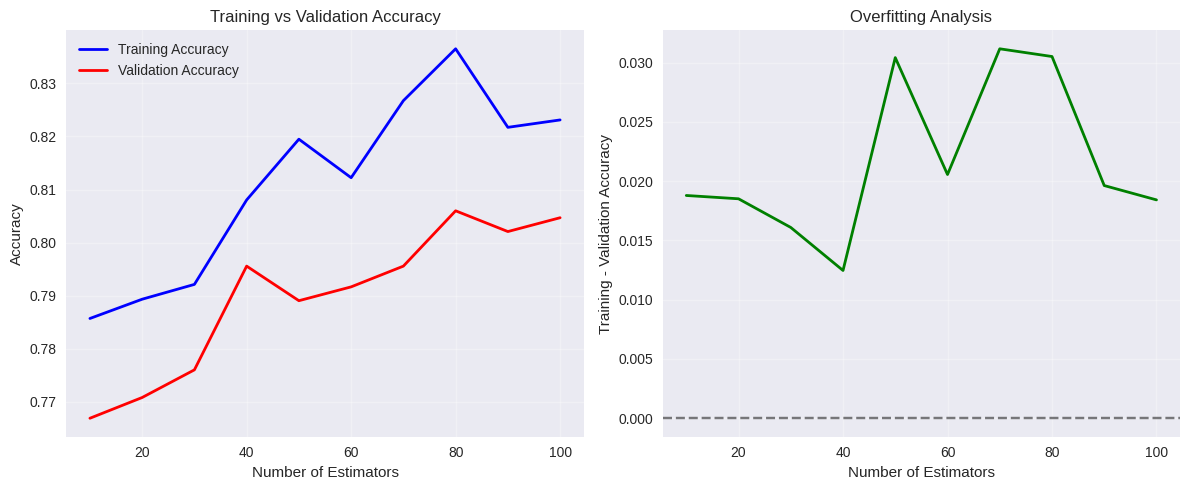

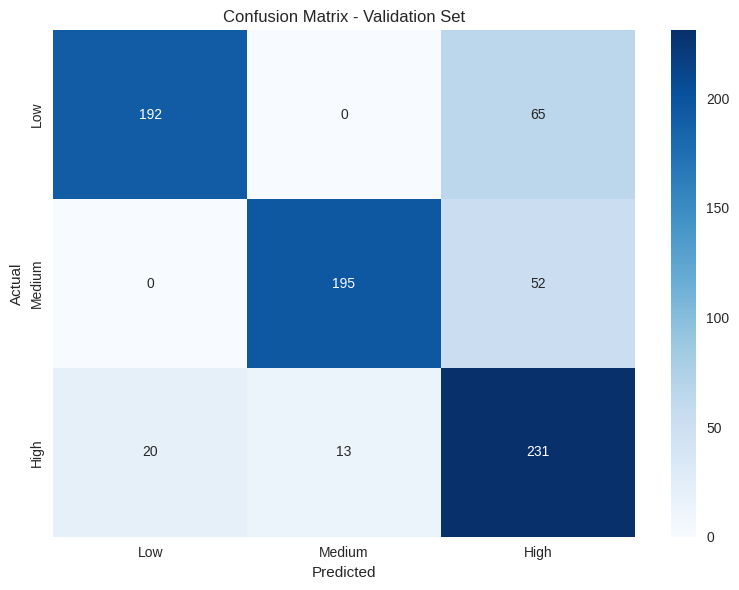

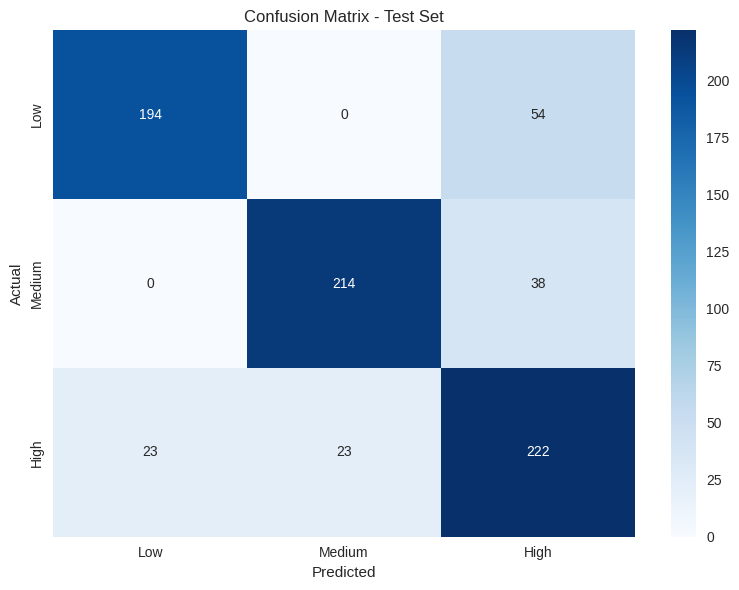

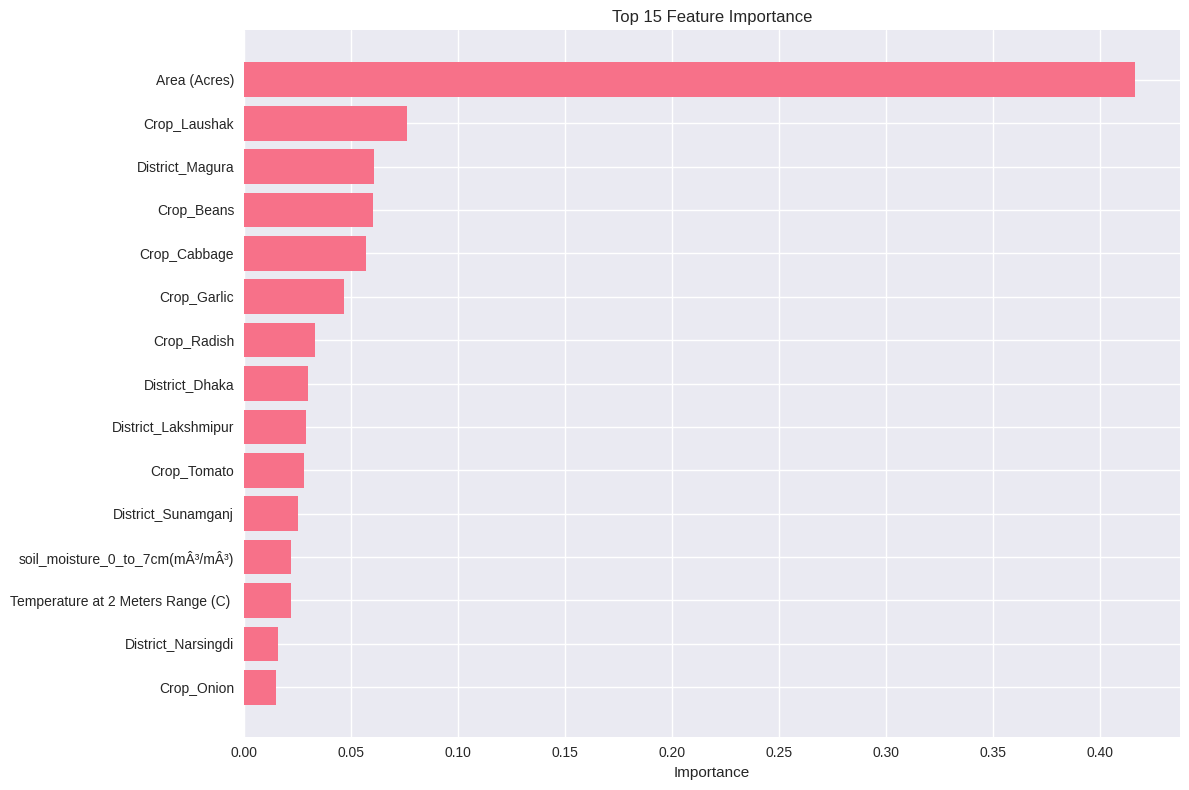


STEP 7: FINAL SUMMARY

Final Performance Summary:
      Dataset  Accuracy  Precision  Recall  F1-Weighted  F1-Macro
0    Training    0.8231     0.8432  0.8231       0.8264    0.8270
1  Validation    0.8047     0.8328  0.8047       0.8092    0.8103
2     Testing    0.8203     0.8317  0.8203       0.8229    0.8242

MACRO F1 SCORES:
Training:   0.8270
Validation: 0.8103
Testing:    0.8242


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class AdaBoostProductionClassifier:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = None
        self.class_names = ['Low', 'Medium', 'High']

    def load_and_preprocess_data(self, train_path, val_path, test_path):
        """Load and preprocess the datasets"""
        print("Loading datasets...")

        # Load datasets
        train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
        val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
        test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

        print(f"Train set shape: {train_df.shape}")
        print(f"Validation set shape: {val_df.shape}")
        print(f"Test set shape: {test_df.shape}")

        # Create labels based on production quantiles (using training data)
        production_col = 'Production (M.Ton)'

        # Calculate quantiles from training data
        quantiles = train_df[production_col].quantile([0.33, 0.67]).values
        print(f"Production quantiles - Low: <{quantiles[0]:.2f}, Medium: {quantiles[0]:.2f}-{quantiles[1]:.2f}, High: >{quantiles[1]:.2f}")

        # Create labels for all datasets
        def create_labels(df, q1, q2):
            labels = []
            for prod in df[production_col]:
                if prod <= q1:
                    labels.append('Low')
                elif prod <= q2:
                    labels.append('Medium')
                else:
                    labels.append('High')
            return labels

        train_df['Label'] = create_labels(train_df, quantiles[0], quantiles[1])
        val_df['Label'] = create_labels(val_df, quantiles[0], quantiles[1])
        test_df['Label'] = create_labels(test_df, quantiles[0], quantiles[1])

        # Separate features and labels
        feature_cols = [col for col in train_df.columns if col not in [production_col, 'Label']]
        self.feature_names = feature_cols

        X_train = train_df[feature_cols]
        y_train = train_df['Label']
        X_val = val_df[feature_cols]
        y_val = val_df['Label']
        X_test = test_df[feature_cols]
        y_test = test_df['Label']

        # Handle missing values
        X_train = X_train.fillna(X_train.mean())
        X_val = X_val.fillna(X_train.mean())  # Use training mean for consistency
        X_test = X_test.fillna(X_train.mean())

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        # Encode labels
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)
        y_test_encoded = self.label_encoder.transform(y_test)

        print("\nLabel distribution:")
        print("Training:", pd.Series(y_train).value_counts().sort_index())
        print("Validation:", pd.Series(y_val).value_counts().sort_index())
        print("Testing:", pd.Series(y_test).value_counts().sort_index())

        return (X_train_scaled, X_val_scaled, X_test_scaled,
                y_train_encoded, y_val_encoded, y_test_encoded,
                y_train, y_val, y_test)

    def train_model_with_epochs(self, X_train, y_train, X_val, y_val, n_epochs=100):
        """Train AdaBoost model with epoch-like iterations"""
        print(f"\nTraining AdaBoost model with {n_epochs} estimators...")

        # Initialize model
        base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
        self.model = AdaBoostClassifier(
            estimator=base_estimator,
            n_estimators=n_epochs,
            learning_rate=1.0,
            random_state=42
        )

        # For tracking performance over epochs
        train_accuracies = []
        val_accuracies = []
        epochs = []

        # Train with increasing number of estimators to simulate epochs
        for n_est in range(10, n_epochs + 1, 10):
            temp_model = AdaBoostClassifier(
                estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                n_estimators=n_est,
                learning_rate=1.0,
                random_state=42
            )
            temp_model.fit(X_train, y_train)

            train_pred = temp_model.predict(X_train)
            val_pred = temp_model.predict(X_val)

            train_acc = accuracy_score(y_train, train_pred)
            val_acc = accuracy_score(y_val, val_pred)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            epochs.append(n_est)

            if n_est % 20 == 0:
                print(f"Estimators: {n_est}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Final training
        self.model.fit(X_train, y_train)
        print("Training completed!")

        return epochs, train_accuracies, val_accuracies

    def calculate_metrics(self, y_true, y_pred, dataset_name):
        """Calculate comprehensive classification metrics"""
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

        print(f"\n{dataset_name} Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print(f"F1-Score (Weighted): {f1_weighted:.4f}")
        print(f"F1-Score (Macro): {f1_macro:.4f}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro
        }

    def plot_confusion_matrix(self, y_true, y_pred, title):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.title(f'Confusion Matrix - {title}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

        return cm

    def plot_training_curves(self, epochs, train_acc, val_acc):
        """Plot training vs validation accuracy"""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2)
        plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
        plt.xlabel('Number of Estimators')
        plt.ylabel('Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, np.array(train_acc) - np.array(val_acc), 'g-', linewidth=2)
        plt.xlabel('Number of Estimators')
        plt.ylabel('Training - Validation Accuracy')
        plt.title('Overfitting Analysis')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, top_n=15):
        """Plot feature importance"""
        if self.model is None:
            print("Model not trained yet!")
            return

        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]

        plt.figure(figsize=(12, 8))
        plt.title(f'Top {top_n} Feature Importance')
        plt.barh(range(top_n), importances[indices])
        plt.yticks(range(top_n), [self.feature_names[i] for i in indices])
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    def generate_classification_report(self, y_true, y_pred, dataset_name):
        """Generate detailed classification report"""
        print(f"\n{dataset_name} Classification Report:")
        print("=" * 50)
        report = classification_report(y_true, y_pred,
                                     target_names=self.class_names,
                                     digits=4)
        print(report)
        return report

# Main execution function
def main():
    """Main function to run the complete pipeline"""

    # Initialize classifier
    classifier = AdaBoostProductionClassifier()

    # File paths (update these paths according to your file locations)
    train_path = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv'
    val_path = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv'
    test_path = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv'

    try:
        # Step 1: Load and preprocess data
        print("="*60)
        print("STEP 1: LOADING AND PREPROCESSING DATA")
        print("="*60)

        (X_train, X_val, X_test,
         y_train_enc, y_val_enc, y_test_enc,
         y_train_orig, y_val_orig, y_test_orig) = classifier.load_and_preprocess_data(
            train_path, val_path, test_path)

        # Step 2: Train model
        print("\n" + "="*60)
        print("STEP 2: TRAINING MODEL")
        print("="*60)

        epochs, train_acc, val_acc = classifier.train_model_with_epochs(
            X_train, y_train_enc, X_val, y_val_enc, n_epochs=100)

        # Step 3: Make predictions
        print("\n" + "="*60)
        print("STEP 3: MAKING PREDICTIONS")
        print("="*60)

        train_pred = classifier.model.predict(X_train)
        val_pred = classifier.model.predict(X_val)
        test_pred = classifier.model.predict(X_test)

        # Step 4: Calculate metrics
        print("\n" + "="*60)
        print("STEP 4: EVALUATION METRICS")
        print("="*60)

        train_metrics = classifier.calculate_metrics(y_train_enc, train_pred, "TRAINING")
        val_metrics = classifier.calculate_metrics(y_val_enc, val_pred, "VALIDATION")
        test_metrics = classifier.calculate_metrics(y_test_enc, test_pred, "TESTING")

        # Step 5: Generate detailed reports
        print("\n" + "="*60)
        print("STEP 5: DETAILED CLASSIFICATION REPORTS")
        print("="*60)

        classifier.generate_classification_report(y_train_enc, train_pred, "TRAINING")
        classifier.generate_classification_report(y_val_enc, val_pred, "VALIDATION")
        classifier.generate_classification_report(y_test_enc, test_pred, "TESTING")

        # Step 6: Visualizations
        print("\n" + "="*60)
        print("STEP 6: GENERATING VISUALIZATIONS")
        print("="*60)

        # Plot training curves
        classifier.plot_training_curves(epochs, train_acc, val_acc)

        # Plot confusion matrices
        classifier.plot_confusion_matrix(y_val_enc, val_pred, "Validation Set")
        classifier.plot_confusion_matrix(y_test_enc, test_pred, "Test Set")

        # Plot feature importance
        classifier.plot_feature_importance()

        # Step 7: Summary
        print("\n" + "="*60)
        print("STEP 7: FINAL SUMMARY")
        print("="*60)

        summary_df = pd.DataFrame({
            'Dataset': ['Training', 'Validation', 'Testing'],
            'Accuracy': [train_metrics['accuracy'], val_metrics['accuracy'], test_metrics['accuracy']],
            'Precision': [train_metrics['precision'], val_metrics['precision'], test_metrics['precision']],
            'Recall': [train_metrics['recall'], val_metrics['recall'], test_metrics['recall']],
            'F1-Weighted': [train_metrics['f1_weighted'], val_metrics['f1_weighted'], test_metrics['f1_weighted']],
            'F1-Macro': [train_metrics['f1_macro'], val_metrics['f1_macro'], test_metrics['f1_macro']]
        })

        print("\nFinal Performance Summary:")
        print(summary_df.round(4))

        # Macro F1 Score emphasis
        print(f"\nMACRO F1 SCORES:")
        print(f"Training:   {train_metrics['f1_macro']:.4f}")
        print(f"Validation: {val_metrics['f1_macro']:.4f}")
        print(f"Testing:    {test_metrics['f1_macro']:.4f}")

    except FileNotFoundError as e:
        print(f"Error: Could not find one of the CSV files. Please make sure the following files exist:")
        print(f"- {train_path}")
        print(f"- {val_path}")
        print(f"- {test_path}")
        print(f"\nError details: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")
        print("Please check your data files and try again.")

# Run the main function
if __name__ == "__main__":
    main()